In [ ]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from plotting import newfig, savefig
from torch.optim.lr_scheduler import StepLR
from IPython.display import display, clear_output
# 1D black sholes

class neural_net(nn.Module):
    def __init__(self, pathbatch=100, n_dim=100 + 1, n_output=1):
        super(neural_net, self).__init__()
        self.pathbatch = pathbatch
        self.fc_1 = nn.Linear(n_dim, 256)
        self.fc_2 = nn.Linear(256, 256)
        self.fc_3 = nn.Linear(256, 256)
        #self.fc_4 = nn.Linear(256, 256)
        self.out = nn.Linear(256, n_output)


        self.relu = nn.ReLU()
        self.prelu = nn.PReLU()
        self.tanh = nn.Tanh()
        self.activation = torch.tanh

        with torch.no_grad():
            torch.nn.init.xavier_uniform(self.fc_1.weight)
            torch.nn.init.xavier_uniform(self.fc_2.weight)
            torch.nn.init.xavier_uniform(self.fc_3.weight)
            #torch.nn.init.xavier_uniform(self.fc_4.weight)

    def forward(self, state, train=False):
        state = self.activation(self.fc_1(state))
        state = self.activation(self.fc_2(state))
        state = self.activation(self.fc_3(state))
        #state = self.activation(self.fc_4(state))
        fn_u = self.out(state)
        return fn_u


class FBSNN(nn.Module):  # Forward-Backward Stochastic Neural Network
    def __init__(self, r,K,sigma ,Xi, T, M, N, D, learning_rate):
        super().__init__()
        self.r = r  # interest rate
        self.sigma = sigma # volatility
        self.K = K  # strike price
        self.Xi = Xi  # initial point
        self.T = T  # terminal time

        self.M = M  # number of trajectories
        self.N = N  # number of time snapshots
        self.D = D  # number of dimensions
        self.fn_u = neural_net(pathbatch=M, n_dim=D + 1, n_output=1)

        self.optimizer = optim.Adam(self.fn_u.parameters(), lr=learning_rate)
        self.scheduler = StepLR(self.optimizer, step_size=800, gamma=0.5)

        self.lambda_ = 10

    def phi_torch(self, t, X, Y, DuDx,DuDt,D2uDx2 ):  # M x 1, M x D, M x 1, M x D

        res = DuDx*self.r*X+DuDt + 0.5*D2uDx2*X**2*self.sigma**2


        return  res # M x 1

    def g_torch(self, X,K):  # M x D

        row_max, _ = torch.max(X, dim=1)  # get maximum along each row

        return torch.clamp(row_max - K, min=0).unsqueeze(1)  # M x 1
    def mu_torch(self, r,t, X, Y):  # 1x1, M x 1, M x D, M x 1, M x D
        return 0*torch.ones([self.M, self.D])  # M x D

    def sigma_torch(self, t, X, Y):  # M x 1, M x D, M x 1
        # print("sigma_torch")
        # print(X.shape)
        return self.sigma * torch.diag_embed(X)  # M x D x D

    def net_u_Du(self, t, X):  # M x 1, M x D

        inputs = torch.cat([t, X], dim=1)

        u = self.fn_u(inputs)


        DuDx = torch.autograd.grad(torch.sum(u), X, retain_graph=True,create_graph=True)[0]

        # print(DuDx.shape)

        DuDt = torch.autograd.grad(torch.sum(u), t, retain_graph=True,create_graph=True)[0]

        D2uDx2 = torch.autograd.grad(torch.sum(DuDx), X, retain_graph=True,create_graph=True)[0]

        return u, DuDx,DuDt,D2uDx2 # M x 1, M x D, M x 1, M x D

    def Dg_torch(self, X):  # M x D
        return torch.autograd.grad(torch.sum(self.g_torch(X,self.K)), X, retain_graph=True)[0]  # M x D

    def fetch_minibatch(self):
        T = self.T
        M = self.M
        N = self.N
        D = self.D

        Dt = np.zeros((M, N + 1, 1))  # M x (N+1) x 1
        DW = np.zeros((M, N + 1, D))  # M x (N+1) x D

        dt = T / N
        Dt[:, 1:, :] = dt
        DW[:, 1:, :] = np.sqrt(dt) * np.random.normal(size=(M, N, D))

        t = np.cumsum(Dt, axis=1)  # M x (N+1) x 1
        W = np.cumsum(DW, axis=1)  # M x (N+1) x D

        return torch.from_numpy(t).float(), torch.from_numpy(W).float()

    def loss_function(self, t, W, Xi):  # M x (N+1) x 1, M x (N+1) x D, 1 x D
        loss = torch.zeros(1)
        X_buffer = []
        Y_buffer = []

        t0 = t[:, 0, :]  # M x 1
        W0 = W[:, 0, :]  # M x D
        # X0 = torch.tensor([np.linspace(0.5,1.5,self.M)]).transpose(-1,-2).float()  # M x D
        # X0 = torch.cat([Xi] * self.M)  # M x D
        X0 = Xi

        X0.requires_grad = True

        t0.requires_grad = True
        Y0, DuDx0,DuDt0,D2uDx20 = self.net_u_Du(t0, X0)  # M x 1, M x D

        X_buffer.append(X0)
        Y_buffer.append(Y0)

        for n in range(0, self.N):
            t1 = t[:, n + 1, :]
            W1 = W[:, n + 1, :]

            #
            # print("t1-t0")
            # print((t1 - t0).shape)
            #
            # print("mu_torch:")
            # print(self.mu_torch(t0, X0, Y0, Z0).shape)
            # print("sigma_torch:")
            # print(self.sigma_torch(t0, X0, Y0).shape)
            # print("W1 - W0:")
            # print((W1 - W0).unsqueeze(-1).shape)
            # print(torch.matmul(self.sigma_torch(t0, X0, Y0), (W1 - W0).unsqueeze(-1)).squeeze(2).shape)

            X1 = X0 + self.r*X0*(t1-t0) + self.sigma * X0 * (W1 - W0) #Euler-M scheme




            # print(X1.shape)

            t1.requires_grad = True
            Y1, DuDx1,DuDt1,D2uDx21 = self.net_u_Du(t1, X1)  # M x 1, M x D

            Y1_tilde = Y0 + self.phi_torch(t0, X0, Y0, DuDx0,DuDt0,D2uDx20) * (t1 - t0) + DuDx0 * self.sigma*X0*(W1-W0)


            loss = loss + torch.sum((Y1 - Y1_tilde) ** 2)

            t0 = t1
            W0 = W1
            X0 = X1
            Y0 = Y1
            DuDx0 = DuDx1 # not sure if this is correct
            DuDt0 = DuDt1
            D2uDx20 = D2uDx21

            X_buffer.append(X0)
            Y_buffer.append(Y0)

        loss = loss + self.lambda_*torch.sum((Y1 - self.g_torch(X1,self.K)) ** 2)
        #loss = loss + torch.sum((Z1 - self.Dg_torch(X1)) ** 2)

        X = torch.stack(X_buffer, dim=1)  # M x N x D
        Y = torch.stack(Y_buffer, dim=1)  # M x N x 1

        return loss, X, Y, Y[0, 0, 0]

    def train(self, N_Iter=10):
        loss_list = []

        start_time = time.time()
        t = np.linspace(0, 1, 10)
        S = np.linspace(0, 2, 10)

        t_mesh, S_mesh = np.meshgrid(t, S)
        for it in range(N_Iter):

            t_batch, W_batch = self.fetch_minibatch()  # M x (N+1) x 1, M x (N+1) x D
            loss, X_pred, Y_pred, Y0_pred = self.loss_function(t_batch, W_batch, self.Xi)

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            self.scheduler.step()
            loss_list.append(loss.detach().numpy()[0])

            # Print
            if it % 50 == 0:
                clear_output(wait=True)
                elapsed = time.time() - start_time
                print('It: %d, Time: %.2f, Loss: %.3e, Y0: %.3f' %
                      (it, elapsed, loss, Y0_pred))
                start_time = time.time()
                plt.plot(np.log10(range(len(loss_list))),np.log10(loss_list))
                plt.show()

                NN_price_surface = np.zeros([10, 10])
                #Exact_price_surface = np.zeros([10, 10])
                for i in range(10):
                    for j in range(10):
                        NN_price_surface[i, j] = model.fn_u(
                            torch.tensor([[t_mesh[i, j], S_mesh[i, j]]]).float()).detach().numpy()

                ax = plt.figure()
                ax = plt.axes(projection='3d')
                ax.plot_surface(t_mesh, S_mesh, NN_price_surface, rstride=1, cstride=1, cmap='viridis',
                                edgecolor='none')
                ax.set_title('surface: iter = %d' % it)
                plt.show()


    def predict(self, Xi_star, t_star, W_star):
        _, X_star, Y_star, _ = self.loss_function(t_star, W_star, Xi_star)

        return X_star, Y_star


It: 1550, Time: 2.83, Loss: 4.567e-02, Y0: 0.198


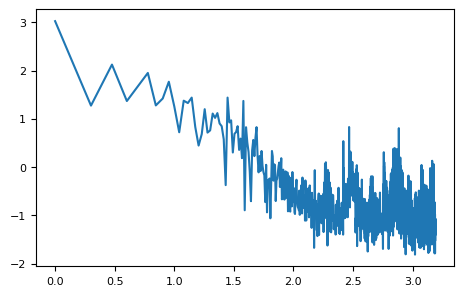

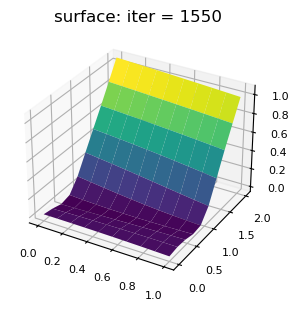

0.1802295145021668


In [86]:

if __name__ == '__main__':
    M = 7 # number of trajectories (batch size)
    N = 15  # number of time snapshots

    learning_rate = 3*1e-3
    epoch = 1600

    r = 0.05
    K = 1.0
    sigma = 0.4
    D = 1  # number of dimensions

    if D==1:
        # Xi = torch.tensor([np.linspace(0.5,2,M)]).transpose(-1,-2).float()
        Xi = torch.ones([M,1])
    else:
        Xi = torch.from_numpy(np.array([1.0, 0.5] * int(D / 2))[None, :]).float()
    T = 1.0

    model = FBSNN(r,K,sigma,Xi, T, M, N, D, learning_rate)

    model.train(N_Iter=epoch)

    t_test, W_test = model.fetch_minibatch()
    X_pred, Y_pred = model.predict(Xi, t_test, W_test)

    from scipy.special import comb
    from scipy.stats import norm

    def theoretical_vanilla_eu(S0=50, K=50, T=1, r=0.05, sigma=0.4, type_='call'):
        '''

        :param S0: 股票当前价格
        :param K: 行权价格
        :param T: 到期时间（年）
        :param r: 无风险利率， 如 r = 0.05
        :param sigma: 波动率， 如 sigma = 0.20
        :param type_:  call or put
        :return: 期权价格
        '''
        if T==0:
            if type_=="call":
                return max(S0-K,0)
            else:
                return max(K-S0,0)
        #求BSM模型下的欧式期权的理论定价
        d1 =( (np.log(S0/K) + (r + 0.5*sigma**2)*T ) )/ (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        if type_== "call":
            c = S0* norm.cdf(d1) - K* np.exp(-r*T)* norm.cdf(d2)
            return c
        elif type_=="put":
            p = K* np.exp(-r*T)* norm.cdf(-d2) - S0* norm.cdf(-d1)

            return p


    def u_exact(t, X):  # (N+1) x 1, (N+1) x D
        r = 0.05
        sigma = 0.4
        K = 1
        T = 1
        res = np.zeros([t.shape[0], X.shape[1]])
        for i in range(t.shape[0]):
            for j in range(X.shape[1]):
                res[i, j] = theoretical_vanilla_eu(S0=X[i, j], K=K, T=T-t[i, 0], r=r, sigma=sigma, type_='call')
        return   res


    t_test = t_test.detach().numpy()
    X_pred = X_pred.detach().numpy()
    Y_pred = Y_pred.detach().numpy()
    Y_test = np.reshape(u_exact(np.reshape(t_test[0:M, :, :], [-1, 1]), np.reshape(X_pred[0:M, :, :], [-1, D])),
                        [M, -1, 1])
    print(Y_test[0, 0, 0])




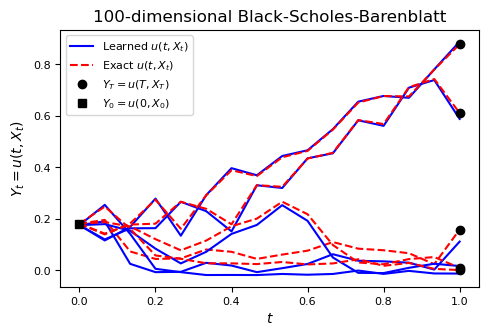

In [87]:
    samples = 5
    plt.figure()
    plt.plot(t_test[0:1, :, 0].T, Y_pred[0:1, :, 0].T, 'b', label=r'Learned $u(t,X_t)$')
    plt.plot(t_test[0:1, :, 0].T, Y_test[0:1, :, 0].T, 'r--', label=r'Exact $u(t,X_t)$')
    plt.plot(t_test[0:1, -1, 0], Y_test[0:1, -1, 0], 'ko', label=r'$Y_T = u(T,X_T)$')

    plt.plot(t_test[1:samples, :, 0].T, Y_pred[1:samples, :, 0].T, 'b')
    plt.plot(t_test[1:samples, :, 0].T, Y_test[1:samples, :, 0].T, 'r--')
    plt.plot(t_test[1:samples, -1, 0], Y_test[1:samples, -1, 0], 'ko')
    plt.plot([0], Y_test[0, 0, 0], 'ks', label=r'$Y_0 = u(0,X_0)$')
    plt.xlabel(r'$t$')
    plt.ylabel(r'$Y_t = u(t,X_t)$')
    plt.title('100-dimensional Black-Scholes-Barenblatt')
    plt.legend()

    #savefig('BSB.png', crop=False)
    plt.show()


C:\Users\Haoya\AppData\Local\Temp\ipykernel_21396\3221402791.py:47: RuntimeWarning: divide by zero encountered in log
  d1 =( (np.log(S0/K) + (r + 0.5*sigma**2)*T ) )/ (sigma * np.sqrt(T))


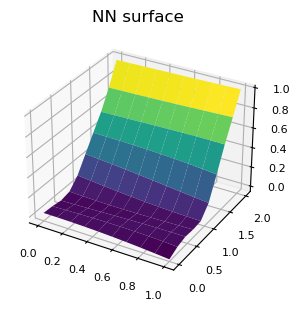

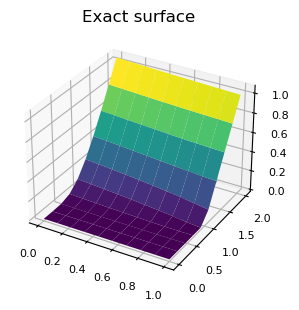

In [84]:
    t = np.linspace(0,1,10)
    S = np.linspace(0,2,10)

    t_mesh, S_mesh = np.meshgrid(t,S)

    NN_price_surface = np.zeros([10,10])
    Exact_price_surface = np.zeros([10,10])
    for i in range(10):
        for j in range(10):
            NN_price_surface[i,j] = model.fn_u(torch.tensor([[t_mesh[i,j], S_mesh[i,j]]]).float()).detach().numpy()
            Exact_price_surface[i,j] = theoretical_vanilla_eu(S0=S_mesh[i,j], K=1, T=1-t_mesh[i,j], r=0.05, sigma=0.4, type_='call')

    ax = plt.figure()
    ax = plt.axes(projection='3d')
    ax.plot_surface(t_mesh, S_mesh, NN_price_surface, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
    ax.set_title('NN surface')
    plt.show()

    ax = plt.figure()
    ax = plt.axes(projection='3d')
    ax.plot_surface(t_mesh, S_mesh, Exact_price_surface, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
    ax.set_title('Exact surface')
    plt.show()





C:\Users\Haoya\AppData\Local\Temp\ipykernel_21396\1656604712.py:50: RuntimeWarning: divide by zero encountered in log
  d1 =( (np.log(S0/K) + (r + 0.5*sigma**2)*T ) )/ (sigma * np.sqrt(T))


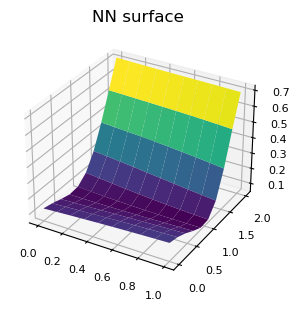

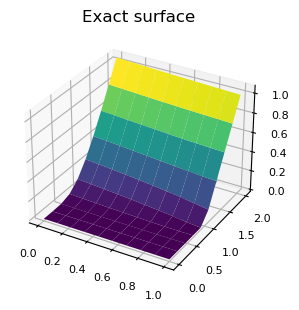

In [76]:
    t = np.linspace(0,1,10)
    S = np.linspace(0,2,10)

    t_mesh, S_mesh = np.meshgrid(t,S)

    NN_price_surface = np.zeros([10,10])
    Exact_price_surface = np.zeros([10,10])
    for i in range(10):
        for j in range(10):
            NN_price_surface[i,j] = model.fn_u(torch.tensor([[t_mesh[i,j], S_mesh[i,j]]]).float()).detach().numpy()
            Exact_price_surface[i,j] = theoretical_vanilla_eu(S0=S_mesh[i,j], K=1, T=1-t_mesh[i,j], r=0.05, sigma=0.4, type_='call')

    ax = plt.figure()
    ax = plt.axes(projection='3d')
    ax.plot_surface(t_mesh, S_mesh, NN_price_surface, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
    ax.set_title('NN surface')
    plt.show()

    ax = plt.figure()
    ax = plt.axes(projection='3d')
    ax.plot_surface(t_mesh, S_mesh, Exact_price_surface, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
    ax.set_title('Exact surface')
    plt.show()





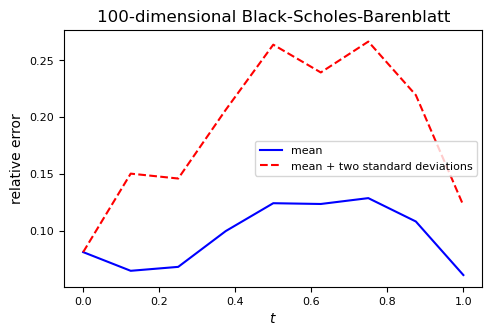

In [77]:
    errors = np.sqrt((Y_test - Y_pred) ** 2 )
    mean_errors = np.mean(errors, 0)
    std_errors = np.std(errors, 0)

    plt.figure()
    plt.plot(t_test[0, :, 0], mean_errors, 'b', label='mean')
    plt.plot(t_test[0, :, 0], mean_errors + 2 * std_errors, 'r--', label='mean + two standard deviations')
    plt.xlabel(r'$t$')
    plt.ylabel('relative error')
    plt.title('100-dimensional Black-Scholes-Barenblatt')
    plt.legend()
    plt.show()

    #savefig('BSB_error.png', crop=False)



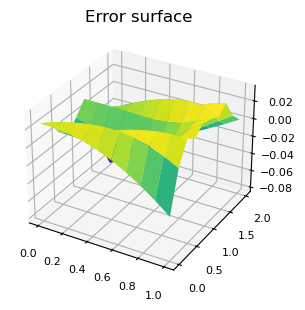

In [89]:
    error_surface = NN_price_surface- Exact_price_surface
    ax = plt.figure()
    ax = plt.axes(projection='3d')
    ax.plot_surface(t_mesh, S_mesh, error_surface, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
    ax.set_title('Error surface')
    plt.show()